In [1]:
import os
import pandas as pd

# Directory where CSV files are stored
csv_directory = '/Users/aimee/Documents/College/Courses/S24/17-735/17735-project/ExtractedData'

# Lists to hold data from each file
logon_data = []
logoff_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Extract time and hour from Timestamp
        df['Time'] = df['Timestamp'].dt.time
        df['Hour'] = df['Timestamp'].dt.hour

        # Append DataFrame to the list by action
        logon_data.append(df[df['Action'] == 'Logon'])
        logoff_data.append(df[df['Action'] == 'Logoff'])

# Concatenate all logon and logoff data into two separate DataFrames
logon_df = pd.concat(logon_data)
logoff_df = pd.concat(logoff_data)

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']


In [2]:
df_user_logon_stats

,User,min,max,mode,mean
0,DTAA/AAA0371,07:35:01,13:46:57,07:54:21,09:00:00
1,DTAA/AAC0344,07:50:03,08:09:53,07:55:54,07:00:00
2,DTAA/AAC0599,07:50:03,08:09:58,07:56:28,07:00:00
3,DTAA/AAH0734,08:20:05,08:39:58,08:30:17,08:00:00
4,DTAA/AAK0658,08:20:00,08:39:54,08:37:53,08:00:00
...,...,...,...,...,...
995,DTAA/ZGH0528,08:35:06,14:54:12,08:36:42,10:00:00
996,DTAA/ZKE0662,07:20:03,13:36:39,07:30:31,09:00:00
997,DTAA/ZKH0388,06:35:00,16:35:13,06:44:54,08:00:00
998,DTAA/ZKN0548,08:20:05,08:39:46,08:25:35,08:00:00


In [3]:
df_user_logoff_stats

,User,min,max,mode,mean
0,DTAA/AAA0371,08:33:18,14:54:58,14:48:22,13:00:00
1,DTAA/AAC0344,15:55:00,16:09:58,16:09:07,15:00:00
2,DTAA/AAC0599,15:55:01,16:09:53,15:56:24,15:00:00
3,DTAA/AAH0734,17:25:00,17:39:59,17:34:26,17:00:00
4,DTAA/AAK0658,16:25:05,16:39:59,16:38:32,16:00:00
...,...,...,...,...,...
995,DTAA/ZGH0528,17:40:01,17:54:58,17:50:07,17:00:00
996,DTAA/ZKE0662,19:25:02,19:39:59,19:36:01,19:00:00
997,DTAA/ZKH0388,07:34:06,17:54:59,17:42:37,16:00:00
998,DTAA/ZKN0548,18:25:01,18:39:54,18:25:07,18:00:00


In [4]:
import numpy as np
def dtt2timestamp(dtt):
  time_in_sec = (dtt.hour*60 + dtt.minute) * 60 + dtt.second
  return time_in_sec

df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


#df_log_on_off_stats.dtypes

log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats)

     on_min_ts  on_max_ts  on_mode_ts  on_mean_ts  off_min_ts  off_max_ts  \
0        27301      49617       28461       32400       27301       49617   
1        28203      29393       28554       25200       28203       29393   
2        28203      29398       28588       25200       28203       29398   
3        30005      31198       30617       28800       30005       31198   
4        30000      31194       31073       28800       30000       31194   
..         ...        ...         ...         ...         ...         ...   
995      30906      53652       31002       36000       30906       53652   
996      26403      48999       27031       32400       26403       48999   
997      23700      59713       24294       28800       23700       59713   
998      30005      31186       30335       28800       30005       31186   
999      32702      33894       32728       32400       32702       33894   

     off_mode_ts  off_mean_ts  
0          28461        32400  
1          

In [5]:
from sklearn.model_selection import train_test_split
# train, test = train_test_split(log_stats_array, test_size=0.2)
train = log_stats_array
test = log_stats_array

In [6]:
import diffprivlib
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.utils import PrivacyLeakWarning
from diffprivlib.mechanisms import PermuteAndFlip
from diffprivlib.validation import DiffprivlibMixin

In [7]:
import numpy as np
import math

class IsolationForestCustom:
    def __init__(self, n_estimators=100, max_samples='auto', max_depth=1, contamination=0.1, random_state=None, epsilon=0.1, accountant=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.contamination = contamination
        self.random_state = random_state
        self.epsilon = epsilon
        self.test_data_size = 0
        self.trees = []
        self.accountant = BudgetAccountant.load_default(accountant)

    def fit(self, X):
        self.accountant.check(self.epsilon, 0)

        num_samples, num_features = X.shape
        self.test_data_size = num_samples
        self.max_samples = self.max_samples if self.max_samples != 'auto' else min(256, num_samples)

        for _ in range(self.n_estimators):
            idx = np.random.choice(num_samples, size=self.max_samples, replace=False)
            tree = self._fit_tree(X[idx], max_depth=self.max_depth)
            self.trees.append(tree)
        
        self.accountant.spend(self.epsilon, 0)

    def _fit_tree(self, X, max_depth):
        if max_depth <= 0 or len(X) <= 1:
            return {'isLeaf': True,
                    'size': len(X)
            }
        num_samples, num_features = X.shape
        feature_idx = np.random.randint(0, num_features)
        split_val = np.random.uniform(X[:, feature_idx].min(), X[:, feature_idx].max())
        
        left_idxs = X[:, feature_idx] < split_val
        right_idxs = ~left_idxs
        
        left_subtree = self._fit_tree(X[left_idxs], max_depth - 1)
        right_subtree = self._fit_tree(X[right_idxs], max_depth - 1)

        return {
            'isLeaf': False,
            'feature_idx': feature_idx,
            'split_val': split_val,
            'left': left_subtree,
            'right': right_subtree
        }

    def c(self, sample_size):
        if (sample_size < 2):
            return 0
        elif (sample_size == 2):
            return 1
        return 2.0 * (math.log(sample_size - 1) + 0.5772156649) - 2.0 * (sample_size - 1) / self.test_data_size

    def predict(self, X):
        num_samples = len(X)
        anomaly_scores = np.zeros(num_samples)
        
        for i, sample in enumerate(X):
            for j, tree in enumerate(self.trees):
                anomaly_scores[i] += self._path_length(sample, tree)
            anomaly_scores[i] = 0.5 - 2 ** (-anomaly_scores[i] / self.n_estimators / self.c(self.max_samples))

        return anomaly_scores

    def _path_length(self, x, tree):
        current_node = tree  # Start from the root node
        path_length = 0
        
        while True:
            if 'size' in current_node:
                return path_length + self.c(current_node['size'])
            feature_idx = current_node['feature_idx']
            split_val = current_node['split_val']
            
            if x[feature_idx] < split_val:  # Traverse left
                current_node = current_node['left']
            else:  # Traverse right
                current_node = current_node['right']
                    
                    
            path_length += 1

In [8]:
accountant = BudgetAccountant(epsilon=0.1)

# Example usage:
# Assuming X_train is your training data
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1, accountant=accountant)
iforest_custom.fit(train)

# Assuming X_test is your test data
# Use the trained model to predict anomaly scores for the test data
anomaly_scores = iforest_custom.predict(test)
print(anomaly_scores)

df22 = pd.Series(anomaly_scores)
df22 = df22.map({1:0, -1:1})
print(df22.value_counts())

[ 1.82431968e-02  1.87193271e-02  1.87193271e-02  1.96954650e-02
  1.91908680e-02  1.96954650e-02  1.87193271e-02  1.77162374e-02
  1.31384386e-02  1.85125759e-02  1.70479876e-02  1.53879877e-02
  1.87193271e-02 -1.49892145e-02 -1.01336228e-02  1.39290387e-02
  1.81070159e-02  1.58214159e-02  2.00467872e-02  1.84247021e-02
  1.34152496e-02  1.91908680e-02  2.00467872e-02  1.58214159e-02
 -1.87514879e-02  1.62358559e-02  1.43823765e-02  1.71991869e-02
 -1.91631538e-02  2.03026199e-02  1.34152496e-02  1.87193271e-02
  1.58214159e-02 -1.47473730e-02  1.87193271e-02  1.87193271e-02
  1.36519933e-02 -2.47855150e-02  1.87193271e-02  1.34152496e-02
 -2.31424276e-02  8.56340531e-03  1.57612974e-02  1.84247021e-02
  1.36309801e-02 -2.66135645e-02  1.81070159e-02  1.38927697e-02
 -1.67582215e-02 -1.01336228e-02  1.91908680e-02 -1.54039216e-03
  1.53879877e-02  1.83446148e-02  1.34152496e-02 -2.38003955e-02
 -2.54224885e-02  1.81070159e-02  1.39771199e-02  1.96954650e-02
  1.34152496e-02  1.86013

In [9]:
anomaly_count = 0
norm_count = 0
for score in anomaly_scores:
    if score < 0:
        anomaly_count += 1
    else:
        norm_count += 1

In [10]:
anomaly_count

150

In [11]:
norm_count

850

In [12]:
log_ascore = anomaly_scores

df_user_log_result = pd.DataFrame()
df_user_log_result['User'] = df_user_logoff_stats_sec['User']
df_user_log_result['anomaly_score'] = log_ascore
# df_user_log_result.to_csv('user_log_result.csv')
print(df_user_log_result)


outliers = df_user_log_result.loc[df_user_log_result['anomaly_score'] < 0]
print(outliers)

             User  anomaly_score
0    DTAA/AAA0371       0.018243
1    DTAA/AAC0344       0.018719
2    DTAA/AAC0599       0.018719
3    DTAA/AAH0734       0.019695
4    DTAA/AAK0658       0.019191
..            ...            ...
995  DTAA/ZGH0528       0.013652
996  DTAA/ZKE0662       0.014841
997  DTAA/ZKH0388       0.012095
998  DTAA/ZKN0548       0.019695
999  DTAA/ZRR0705       0.010451

[1000 rows x 2 columns]
             User  anomaly_score
13   DTAA/ABS0726      -0.014989
14   DTAA/ACD0647      -0.010134
24   DTAA/AFF0760      -0.018751
28   DTAA/AFO0022      -0.019163
33   DTAA/AGW0182      -0.014747
..            ...            ...
967  DTAA/WOT0549      -0.020040
970  DTAA/WTA0867      -0.020976
972  DTAA/XCB0445      -0.017856
975  DTAA/XIN0791      -0.017668
990  DTAA/ZAB0889      -0.017413

[150 rows x 2 columns]


array([[<AxesSubplot:title={'center':'min_ts'}>,
        <AxesSubplot:title={'center':'max_ts'}>],
       [<AxesSubplot:title={'center':'mode_ts'}>,
        <AxesSubplot:title={'center':'mean_ts'}>]], dtype=object)

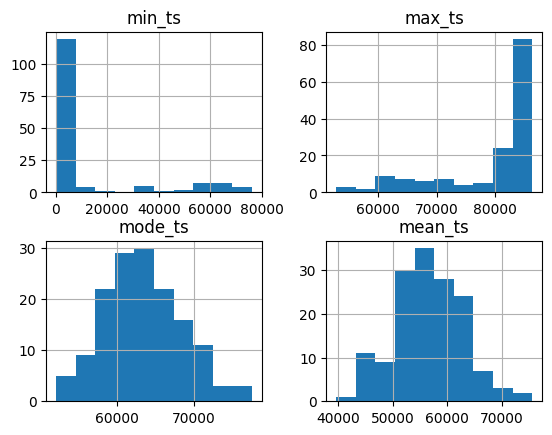

In [25]:
df_user_logoff_stats_sec.loc[df_user_log_result['anomaly_score'] < 0].hist()

In [13]:
# Lists to hold data from each file
connect_data = []
disconnect_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Filter DataFrame by action and append to the respective list
        connect_data.append(df[df['Action'] == 'Connect'])
        disconnect_data.append(df[df['Action'] == 'Disconnect'])

# Concatenate all connect and disconnect data into two separate DataFrames
connect_df = pd.concat(connect_data)
disconnect_df = pd.concat(disconnect_data)

# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

In [14]:
# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)

In [15]:
# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values

In [37]:

train = device_full_array
test = device_full_array

accountant = BudgetAccountant(epsilon=0.1)

# Example usage:
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1, accountant=accountant)
iforest_custom.fit(train)

# Use the trained model to predict anomaly scores for the test data
df_device_full['anomaly_score'] = iforest_custom.predict(test)

df_device_full_outliers = df_device_full[df_device_full['anomaly_score'] < 0]
print(df_device_full_outliers)

             User Connect_min_time Connect_max_time Connect_mean_time  \
46   DTAA/CMF0339         03:00:27         05:03:03          16:20:42   
51   DTAA/CTR0537         00:54:40         21:55:26          22:54:48   
61   DTAA/DFZ0063         23:22:27         21:57:51          13:09:24   
98   DTAA/HNS0858         21:45:26         23:33:49          02:41:34   
107  DTAA/JAH0544         03:29:41         23:07:03          20:09:49   
109  DTAA/JBL0450         00:36:02         00:13:17          21:42:22   
135  DTAA/KSP0927         06:55:57         23:20:29          22:40:53   
226  DTAA/ZAB0889         02:19:27         22:27:47          15:58:17   

    Connect_mode_time Connect_min_time_ts  Connect_min_time_sec  \
46           02:52:04            03:00:27                 10827   
51           00:05:36            00:54:40                  3280   
61           00:36:34            23:22:27                 84147   
98           00:07:21            21:45:26                 78326   
107    

In [38]:
df_all = pd.DataFrame()

# Read all CSV files and concatenate into a single DataFrame
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        df_temp = pd.read_csv(file_path, header=None)  # Assuming the CSV has no header
        df_temp.columns = ['User', 'Timestamp', 'PC', 'Activity', 'Action']  # Assign column names
        df_all = pd.concat([df_all, df_temp])

# Ensure 'Timestamp' is a datetime object
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'], format='%m/%d/%Y %H:%M:%S')

# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_all[df_all['Action'] == 'Logon']
df_logoff = df_all[df_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [39]:
df_user_pc_logon.sort_values('unique_pc_count')

,User,unique_pc_count
22291,DTAA/ZRR0705,1
14686,DTAA/JMR0955,1
14687,DTAA/JMS0793,1
20426,DTAA/SBB0044,1
14728,DTAA/JPP0841,1
...,...,...
13399,DTAA/JCC0998,874
9879,DTAA/ELD1000,876
8740,DTAA/DSM0990,884
15941,DTAA/KEE0997,909


In [40]:
pc_counts = np.array(df_user_pc_logon['unique_pc_count']).reshape(-1, 1)

train = pc_counts
test = pc_counts

accountant = BudgetAccountant(epsilon=0.1)

# Example usage:
iforest_custom = IsolationForestCustom(n_estimators=100, contamination=0.1, epsilon=0.1, accountant=accountant)
iforest_custom.fit(train)

anomaly_scores = iforest_custom.predict(test)

In [41]:
import pickle

# Serialize the model using pickle
with open('user_pc_ct_isolation_forest.pkl', 'wb') as file:
    pickle.dump(iforest_custom, file)

# Create a DataFrame to hold the results
results = pd.DataFrame()
results['user'] = df_user_pc_logon['User']
results['unique_pc_count'] = df_user_pc_logon['unique_pc_count']
results['anomaly_score'] = anomaly_scores

# Identify potential outliers
# Outliers are defined as observations with an anomaly score less than 0
df_unique_pc_outliers = results.loc[results['anomaly_score'] < 0]

# Display the results
print(results.head(10))  # Show the first 10 results
print(df_unique_pc_outliers)          # Show the outliers

             user  unique_pc_count  anomaly_score
0    DTAA/AAA0371               16       0.025535
16   DTAA/AAC0344                1       0.027460
17   DTAA/AAC0599                1       0.027460
18   DTAA/AAH0734                1       0.027460
19   DTAA/AAK0658                1       0.027460
20   DTAA/AAK0924                1       0.027460
21   DTAA/AAR0508                1       0.027460
22   DTAA/AAS0709               19       0.025535
41   DTAA/ABB0272               72       0.016627
113  DTAA/ABD0833                1       0.027460
               user  unique_pc_count  anomaly_score
992    DTAA/ARS0993              846      -0.265765
2325   DTAA/BJM0992              865      -0.275280
3933   DTAA/CGM0994              928      -0.302606
5142   DTAA/CLB0995              846      -0.265765
6005   DTAA/CLN0999              865      -0.275280
6966   DTAA/CRC0996              855      -0.269928
8740   DTAA/DSM0990              884      -0.286097
9879   DTAA/ELD1000              8

In [42]:
df_user_log_result.head()

df_threat_users_log = df_user_log_result.loc[df_user_log_result['anomaly_score'] <= -0.04]
print(df_threat_users_log)

             User  anomaly_score
90   DTAA/ARS0993      -0.040683
217  DTAA/CLN0999      -0.043620
231  DTAA/CRC0996      -0.043620
294  DTAA/DSM0990      -0.041380
326  DTAA/ELD1000      -0.040417
374  DTAA/GRS0372      -0.047180
459  DTAA/JCC0998      -0.043432
680  DTAA/NHH0566      -0.042253


In [22]:
import matplotlib.pyplot as plt

/Users/aimee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys


             User Connect_min_time Connect_max_time Connect_mean_time  \
46   DTAA/CMF0339         03:00:27         05:03:03          16:20:42   
51   DTAA/CTR0537         00:54:40         21:55:26          22:54:48   
61   DTAA/DFZ0063         23:22:27         21:57:51          13:09:24   
98   DTAA/HNS0858         21:45:26         23:33:49          02:41:34   
107  DTAA/JAH0544         03:29:41         23:07:03          20:09:49   
109  DTAA/JBL0450         00:36:02         00:13:17          21:42:22   
135  DTAA/KSP0927         06:55:57         23:20:29          22:40:53   
226  DTAA/ZAB0889         02:19:27         22:27:47          15:58:17   

    Connect_mode_time Connect_min_time_ts  Connect_min_time_sec  \
46           02:52:04            03:00:27                 10827   
51           00:05:36            00:54:40                  3280   
61           00:36:34            23:22:27                 84147   
98           00:07:21            21:45:26                 78326   
107    

,User,Connect_min_time,Connect_max_time,Connect_mean_time,Connect_mode_time,Connect_min_time_ts,Connect_min_time_sec,Connect_max_time_ts,Connect_max_time_sec,Connect_mode_time_ts,...,Disconnect_mode_time,Disconnect_min_time_ts,Disconnect_min_time_sec,Disconnect_max_time_ts,Disconnect_max_time_sec,Disconnect_mode_time_ts,Disconnect_mode_time_sec,Disconnect_mean_time_ts,Disconnect_mean_time_sec,anomaly_score
46,DTAA/CMF0339,03:00:27,05:03:03,16:20:42,02:52:04,03:00:27,10827,05:03:03,18183,02:52:04,...,00:33:42,03:02:07,10927,23:52:52,85972,00:33:42,2022,13:45:02,49502,-0.004463
51,DTAA/CTR0537,00:54:40,21:55:26,22:54:48,00:05:36,00:54:40,3280,21:55:26,78926,00:05:36,...,03:17:19,03:17:19,11839,22:57:02,82622,03:17:19,11839,01:07:01,4021,-0.005926
61,DTAA/DFZ0063,23:22:27,21:57:51,13:09:24,00:36:34,23:22:27,84147,21:57:51,79071,00:36:34,...,00:25:21,03:24:31,12271,22:23:23,80603,00:25:21,1521,00:34:17,2057,-0.000931
98,DTAA/HNS0858,21:45:26,23:33:49,02:41:34,00:07:21,21:45:26,78326,23:33:49,84829,00:07:21,...,01:20:48,03:32:24,12744,23:36:27,84987,01:20:48,4848,23:12:54,83574,-0.006775
107,DTAA/JAH0544,03:29:41,23:07:03,20:09:49,00:44:50,03:29:41,12581,23:07:03,83223,00:44:50,...,01:24:25,04:08:20,14900,23:47:32,85652,01:24:25,5065,20:59:38,75578,-0.004633
109,DTAA/JBL0450,00:36:02,00:13:17,21:42:22,00:05:11,00:36:02,2162,00:13:17,797,00:05:11,...,00:14:56,00:38:35,2315,00:17:15,1035,00:14:56,896,21:44:30,78270,-0.001270
135,DTAA/KSP0927,06:55:57,23:20:29,22:40:53,00:05:23,06:55:57,24957,23:20:29,84029,00:05:23,...,00:04:11,06:57:38,25058,23:45:33,85533,00:04:11,251,06:38:53,23933,-0.001186
226,DTAA/ZAB0889,02:19:27,22:27:47,15:58:17,00:28:50,02:19:27,8367,22:27:47,80867,00:28:50,...,00:33:59,02:26:51,8811,23:44:55,85495,00:33:59,2039,01:52:47,6767,-0.007019


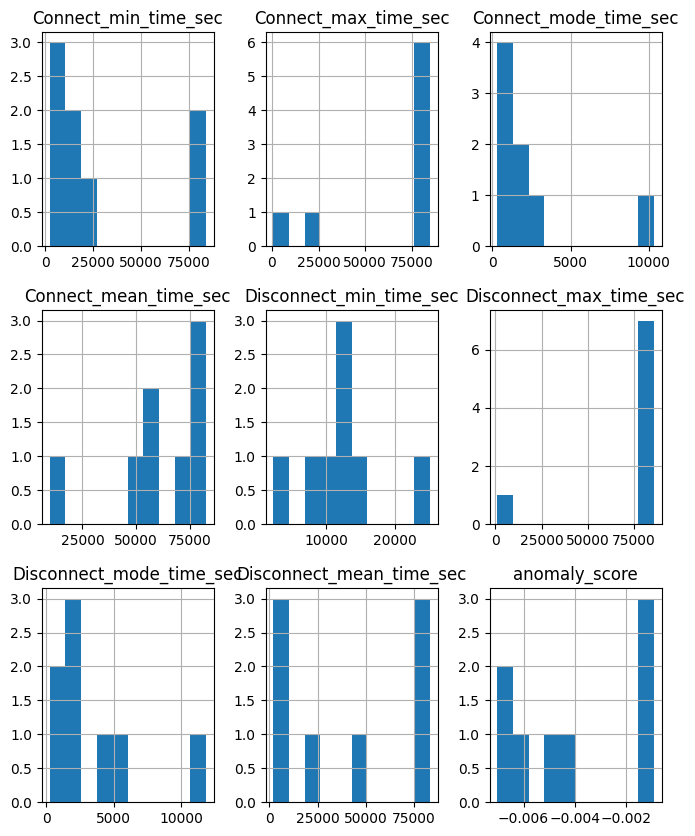

In [43]:
df_device_full_outliers.head()


fig = plt.figure(figsize=(8,10))
ax = fig.gca()

df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] < 0].hist(ax=ax)

df_threat_users_device_file = df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] <= 0]
print(df_threat_users_device_file)

df_device_full[df_device_full.User.isin(df_threat_users_device_file.User)]

               user  unique_pc_count  anomaly_score
992    DTAA/ARS0993              846      -0.265765
2325   DTAA/BJM0992              865      -0.275280
3933   DTAA/CGM0994              928      -0.302606
5142   DTAA/CLB0995              846      -0.265765
6005   DTAA/CLN0999              865      -0.275280
6966   DTAA/CRC0996              855      -0.269928
8740   DTAA/DSM0990              884      -0.286097
9879   DTAA/ELD1000              876      -0.280670
12333  DTAA/IRC0991              866      -0.275280
13399  DTAA/JCC0998              874      -0.275280
14824  DTAA/JTT0989              862      -0.275280
15941  DTAA/KEE0997              909      -0.297065


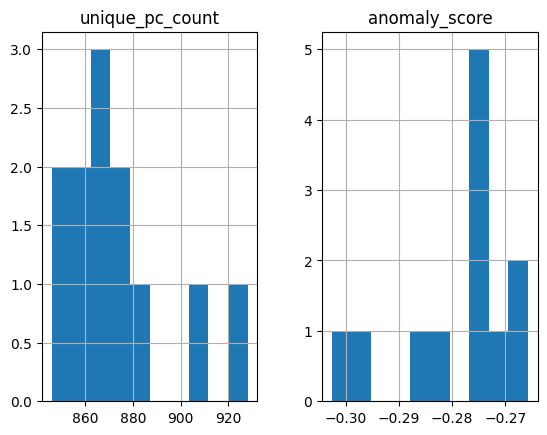

In [44]:


df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] < 0].hist()

df_threat_users_unique_pc = df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] <= 0]
print(df_threat_users_unique_pc)